In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [7]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)
device

Device: cuda 11 / 24 / 2020


device(type='cuda')

In [8]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

In [9]:
start_array_pos = 0
end_array_pos = 1000

# add double().to(device) to move the data to GPU
noise_set = torch.from_numpy(ecg_noisy).double().to(device)
clean_set = torch.from_numpy(ecg_clean).double().to(device)

# Combined dataset of noise + clean on a single dataset will be used with enumerate
combined_dataset = torch.utils.data.TensorDataset( noise_set, clean_set) # CPU version
trainloader = DataLoader( combined_dataset, batch_size=1, shuffle=True)

In [10]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1024, 1, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [39]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam( model.parameters() )
    
    for epoch in range(epochs):
        # Running loss computed at the end
        running_loss = 0.0        
        # start timer
        epoch_start = time.time()
        # Loop through the entire dataset
        for i, (noise_sig, clean_sig) in enumerate(trainloader):
            optimizer.zero_grad()
            x_prime = model( noise_sig )
            loss = criterion( x_prime, noise_sig)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        # ===== Epoch timer =====
        epoch_end = time.time()
        time_total = epoch_end - epoch_start
        print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
        # ===== Total training elapsed time =====
    elapsed_end = time.time()
    elapsed_total = elapsed_end-elapsed_start
    elapsed_mins = int(elapsed_total/60)
    elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
    print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

    return train_loss

In [40]:
model = ae_sampler().cuda()
model.double()
losses = train_model( model, trainloader, 2)
# train_model( ae_sampler, noiseloader, 1)

Epoch 1 of 2 || time: 42.60 || loss = 0.0010003730674509452
Epoch 2 of 2 || time: 41.91 || loss = 0.000756101236664585
Elapsed time: 84.51, (in mins: 1:24)


In [34]:
x = model.encoder(noise_set)
x = model.decoder(x)
x = x.cpu()
x = x.detach().numpy()

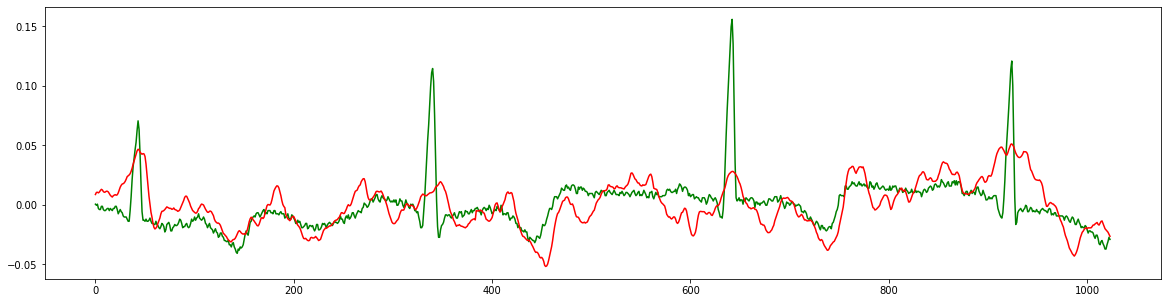

In [35]:
index_chk = 0
clean_set_cpu = clean_set.cpu()
if x.shape[2] == 1:
    plt.figure(figsize=(20,5))
    plt.plot( clean_set_cpu[index_chk], c='green' )
    plt.plot( x[index_chk], c='red' )
else:
    print("Shape is too large")

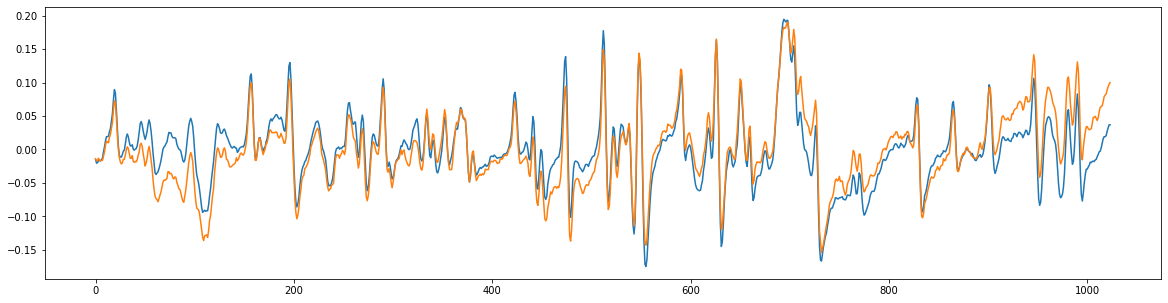

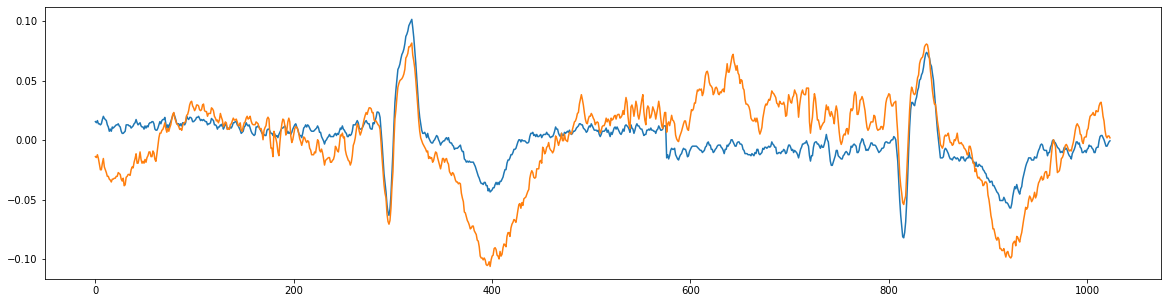

In [31]:
def convert_sig_to_numpy(input_sig):
    temp_sig = input_sig
    temp_sig = temp_sig.view( temp_sig.shape[1], 1)
    temp_sig = temp_sig.cpu()
    temp_sig = temp_sig.detach().numpy()
    return temp_sig

for i, (noise_sig, clean_sig) in enumerate(trainloader):
    temp_sig_noise = convert_sig_to_numpy(noise_sig)
    temp_sig_clean = convert_sig_to_numpy(clean_sig)

    plt.figure(figsize=(20,5))
    plt.plot( temp_sig_clean )
    plt.plot( temp_sig_noise )
    if i == 1:
        break